In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import statsmodels.api as sm

In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
# Setup your PBSCluster

project = 'P93300641' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='03:30:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(25)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34145 instead
  f"Port {expected} is already in use.\n"


In [3]:
client.cluster

In [4]:
def lens_files(datavar,cmp,tape,yr):
    topdir = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+cmp+'/proc/tseries/'

    freqs={'atm':{'h0':'month_1','h1':'day_1'},
           'lnd':{'h0':'month_1','h5':'day_1','h7':'hour_3'}}
    freq=freqs[cmp][tape]
    s='/'
    d=topdir+freq+s+datavar+s
    files=np.array(sorted(glob.glob(d+'*smbb*'+tape+'*')))
    yr1s = np.array([int(f.split('.')[-2].split('-')[0][:4]) for f in files])
    yr2s = np.array([int(f.split('.')[-2].split('-')[1][:4]) for f in files])
    ix =(yr1s<=yr)&(yr2s>=yr)
    
    return files[ix]

In [8]:
def brown_green():
    '''
    returns a colormap based on colorbrewer diverging brown->green
    '''

    # colorbrewer colormap, diverging, brown->green
    cmap = np.zeros([11,3]);
    cmap[0,:] = 84,48,5
    cmap[1,:] = 140,81,10
    cmap[2,:] = 191,129,45
    cmap[3,:] = 223,194,125
    cmap[4,:] = 246,232,195
    cmap[5,:] = 245,245,245
    cmap[6,:] = 199,234,229
    cmap[7,:] = 128,205,193
    cmap[8,:] = 53,151,143
    cmap[9,:] = 1,102,94
    cmap[10,:] = 0,60,48
    cmap = matplotlib.colors.ListedColormap(cmap/256)
    
    return cmap

In [9]:
bg = brown_green()
rwb0=[[103,0,31],
[178,24,43],
[214,96,77],
[244,165,130],
[253,219,199],
[247,247,247],
[209,229,240],
[146,197,222],
[67,147,195],
[33,102,172],
[5,48,97]]
rwb=matplotlib.colors.ListedColormap(np.flipud(np.array(rwb0))/256)
bwr=matplotlib.colors.ListedColormap((np.array(rwb0))/256)

In [10]:
bb=[[247,251,255],
[222,235,247],
[198,219,239],
[158,202,225],
[107,174,214],
[66,146,198],
[33,113,181],
[8,81,156],
[8,48,107]]

bb=matplotlib.colors.ListedColormap(np.array(bb)/256)

In [5]:
def get_data(dvs,cmp,tape,yr,a=slice(30,40),o=slice(241,257)):
    
    if type(dvs)==str:
        dvs=[dvs]
    
    nts={'h0':12,'h1':365,'h5':365,'h7':2920}
    nt = nts[tape]

    files = lens_files(dvs[0],cmp,tape,yr)
    ds = xr.open_dataset(files[0]).sel(lat=a,lon=o)
      
    for dv in dvs:
        files = lens_files(dv,cmp,tape,yr)
        def preprocess(ds):
            return ds[dv].sel(lat=a,lon=o)
        da = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                             parallel=True,chunks={'time':nt},preprocess=preprocess)
        ds[dv]=da
    
    if tape=='h0':
        nmonths = len(ds.time)
        yr0 = ds['time.year'].values[0]
        ds['time'] = xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    
    
    return ds
    

In [6]:
def get_files(cmp,tape,yr,i='i04',suff='_climo/'):
    

    d0='/glade/campaign/asp/djk2120/mapp/'
    d1=str(yr)+suff
    m='*nudge*'+i+'*'
    mems = sorted(glob.glob(d0+d1+m))

    files = [sorted(glob.glob(mem+'/'+cmp+'/hist/'+'*.'+tape+'.*')) for mem in mems]

    return files



In [7]:
def get_ds(dvs,cmp,htape,yr,i='i04',suff='_climo/',a=slice(30,40),o=slice(241,257)):

    files = get_files(cmp,htape,yr,i=i,suff=suff)
    
    def preprocess(ds):
        return ds[dvs].sel(lat=a,lon=o)
    
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                           parallel=True,preprocess=preprocess)    
    if htape=='h0':
        m0 = 12-len(ds.time)
        ds['time'] = xr.cftime_range(str(yr),periods=12,freq='MS')[m0:]
        
        
    return ds

In [9]:
yys = ['2020','2090']
ims = ['i04','i07']
yrs = [yy for yy in ['2020','2090'] for i in ['i04','i07']]
ims = [i for yy in ['2020','2090'] for i in ['i04','i07']]
a=slice(30,40)
o=slice(241,257)
f=get_files('lnd','h0','2020')[0][0]
tmp=xr.open_dataset(f)
la = (tmp.area*tmp.landfrac).sel(lat=a,lon=o)

In [39]:
dvs=['RAIN','EFLX_LH_TOT','TSA','RH2M']
dsets={2020:{},2090:{}}
for yr in [2020,2090]:
    dsets[yr]['lens']=get_data(dvs,'lnd','h0',yr)
    for im in ['i04','i07']:
        dsets[yr][im]=get_ds(dvs,'lnd','h0',yr,i=im)
        
    

In [65]:
cf1=24*60*60
cfs={}
cfs['RAIN']=cf1
cfs['SNOW']=cf1
cfs['EFLX_LH_TOT']=cf1/2.5e6

In [67]:
def calc_x(ds,v):
    ix=(ds['time.month']>=7)&(ds['time.month']<=9)
    m=ds['time.days_in_month']
    mt=m.isel(time=ix).groupby('time.year').sum()[0].values

    if v=='VP':
        t=ds.TSA-273.15
        rh=ds.RH2M/100
        es=0.61094*np.exp(17.625*t/(t+234.04))
        da=rh*es
    else: 
        da=ds[v]
    if v in cfs:
        cf = cfs[v]
    else:
        cf = 1
    x=cf/mt*savg((m*da).isel(time=ix)).groupby('time.year').sum().compute()
    return x

In [71]:
data={}
for yr in [2020,2090]:
    data[yr]={}
    for ee in ['lens','i04','i07']:
        print(yr,ee)
        data[yr][ee]={}
        for v in [*dvs,'VP']:
            ds=dsets[yr][ee]
            data[yr][ee][v]=calc_x(ds,v)

2020 lens
2020 i04
2020 i07
2090 lens
2090 i04
2090 i07


In [130]:
def three_hist(v,xlab):
    plt.figure(figsize=[12,3])
    i=0
    xmin=np.inf
    xmax=-np.inf
    for e in ['lens','i04','i07']:
        i+=1
        plt.subplot(1,3,i)
        plt.title(ts[i-1]);
        for y in [2020,2090]:
            x=data[y][e][v].values.ravel()
            plt.hist(x,alpha=0.75,label=str(y))
            
            if i>1:
                if x.min()<xmin: xmin=x.min()
                if x.max()>xmax: xmax=x.max()
                
        plt.legend()
        plt.xlabel(xlab)
        plt.ylabel('nEns')
        
    for i in [2,3]:
        plt.subplot(1,3,i)
        plt.xlim([0.98*xmin,1.02*xmax])
            
    if v=='TSA':
        for i in [1,2,3]:
            plt.subplot(1,3,i)
            plt.xlim([297.5,306.5])

In [134]:
units={'TSA':'K',
       'RH2M':'%',
       'RAIN':'mm/d',
       'EFLX_LH_TOT':'mm/d',
       'VP':'kPa'}

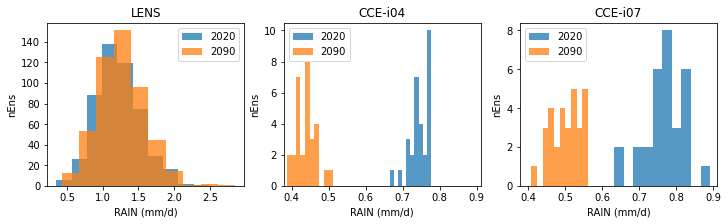

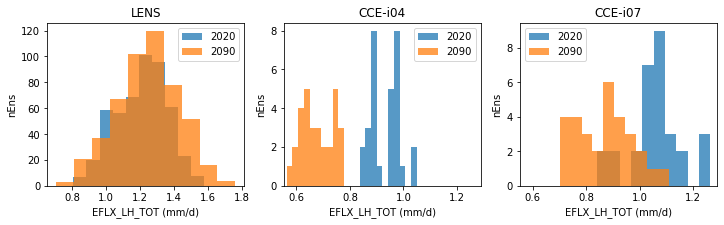

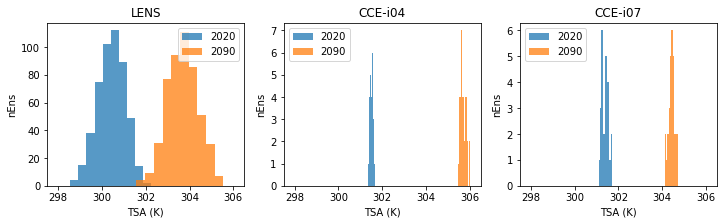

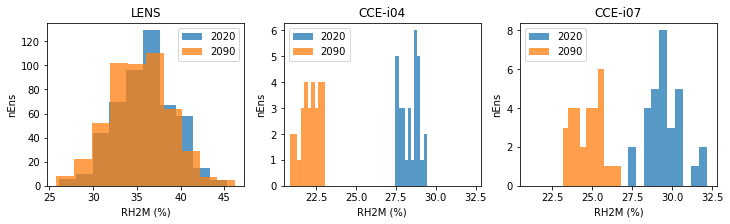

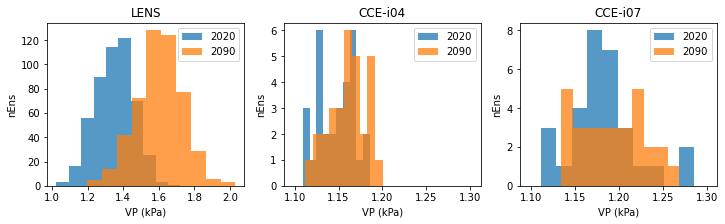

In [135]:
for v in [*dvs,'VP']:
    three_hist(v,v+' ('+units[v]+')')

In [148]:
c={};m={}
c[2020]=np.array([83,152,198])/256
c[2090]=np.array([242,166,67])/256
m['lens']='.'
m['i04']='.'
m['i07']='+'

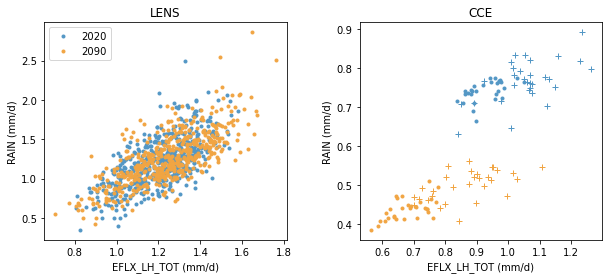

In [158]:
v1='EFLX_LH_TOT'
v2='RAIN'

plt.figure(figsize=[10,4])
plt.subplot(121)
ee='lens'
for yr in [2020,2090]:
    x=data[yr][ee][v1].values.ravel()
    y=data[yr][ee][v2].values.ravel()
    plt.plot(x,y,m[ee],color=c[yr],label=yr)
plt.title('LENS')
plt.legend()

plt.subplot(122)
for ee in ['i04','i07']:
    for yr in [2020,2090]:
        x=data[yr][ee][v1]
        y=data[yr][ee][v2]
        plt.plot(x,y,m[ee],color=c[yr])
plt.title('CCE')

plt.subplots_adjust(wspace=0.3)
for i in [1,2]:
    plt.subplot(1,2,i)
    plt.xlabel(v1+' ('+units[v1]+')')
    plt.ylabel(v2+' ('+units[v2]+')')

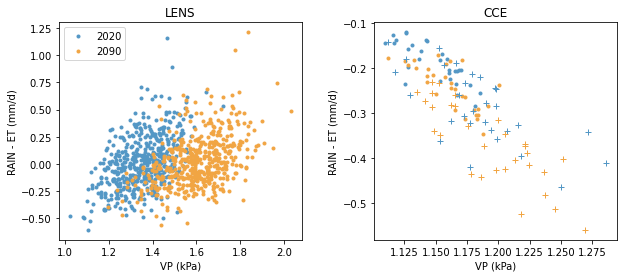

In [159]:
v1='VP'
v2='RAIN - ET'

plt.figure(figsize=[10,4])
plt.subplot(121)
ee='lens'
for yr in [2020,2090]:
    x=data[yr][ee][v1]
    y=data[yr][ee]['RAIN']-data[yr][ee]['EFLX_LH_TOT']
    plt.plot(x.values.ravel(),y.values.ravel(),m[ee],color=c[yr],label=yr)
plt.title('LENS')
plt.legend()

plt.subplot(122)
for ee in ['i04','i07']:
    for yr in [2020,2090]:
        x=data[yr][ee][v1]
        y=data[yr][ee]['RAIN']-data[yr][ee]['EFLX_LH_TOT']
        plt.plot(x,y,m[ee],color=c[yr])
plt.title('CCE')

plt.subplots_adjust(wspace=0.3)
for i in [1,2]:
    plt.subplot(1,2,i)
    plt.xlabel(v1+' ('+units[v1]+')')
    plt.ylabel('RAIN - ET (mm/d)')